特徴量として、エントロピーと閉じかっこを選択。SQLインジェクションの含まれるhttpクエリ文字列と含まれない文字列で特徴量の違いを確認。

In [1]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [2]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [3]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [4]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [5]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))


In [6]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

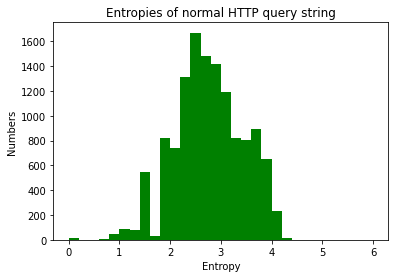

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

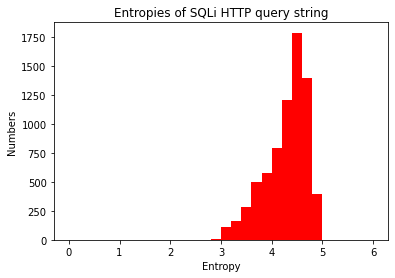

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

In [9]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli


,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


閉じかっこの存在率(sqli)

In [10]:
print('{:.2%}'.format(
    df_sqli['payload'].str.contains('\)').sum() \
    / len(df_sqli['payload'])
    )
)

90.91%


閉じかっこの存在率(norm)

In [11]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(
    df_norm['payload'].str.contains('\)').sum() \
    / len(df_norm['payload'])
    )
)

0.01%


In [12]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、
        # ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [13]:
df = func_preprocessing(df)

In [14]:
df

,payload,length,attack_type,label,entropy,closing_parenthesis
0,c/ caridad s/n,14,norm,0,3.093069,0
1,"campello, el",12,norm,0,3.022055,0
2,1442431887503330,16,norm,0,2.827820,0
3,nue37,5,norm,0,2.321928,0
4,tufts3@joll.rs,14,norm,0,3.378783,0
...,...,...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,1,4.064392,1
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,1,4.718866,1
20362,"1"" order by 1--",15,sqli,1,3.189898,0
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,1,4.641613,1


7.4 SQLインジェクション検出器の開発

エントロピーと閉じ括弧の有無を特徴量として検出器を作成。交差検証し汎化性能を評価。

In [15]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

ラベルと特徴量のデータ

In [18]:
X_all

,length,entropy,closing_parenthesis
0,14,3.093069,0
1,12,3.022055,0
2,16,2.827820,0
3,5,2.321928,0
4,14,3.378783,0
...,...,...,...
10176,113,4.422041,1
10177,113,4.514233,1
10178,136,4.630369,1
10179,111,4.539371,1


In [19]:
y_all

,label
0,0
1,0
2,0
3,0
4,0
...,...
10176,1
10177,1
10178,1
10179,1


交差検証(5分割、シャッフルあり)

ハイパーパラメータ探索と交差検証を繰り返し、ハイパーパラメータチューニング

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical(
            'criterion', 
            ['gini', 'entropy']
            ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            1, 64
            )
        }
        model = DecisionTreeClassifier(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2022-09-14 08:48:51,413] A new study created in memory with name: no-name-b5010c75-c54c-4b08-ba70-602ac3062f64
[I 2022-09-14 08:48:52,512] Trial 0 finished with value: 0.9800613942377921 and parameters: {'criterion': 'gini', 'max_depth': 43}. Best is trial 0 with value: 0.9800613942377921.
[I 2022-09-14 08:48:53,201] Trial 1 finished with value: 0.9801857293841673 and parameters: {'criterion': 'gini', 'max_depth': 46}. Best is trial 0 with value: 0.9800613942377921.
[I 2022-09-14 08:48:53,891] Trial 2 finished with value: 0.9802686481238023 and parameters: {'criterion': 'gini', 'max_depth': 33}. Best is trial 0 with value: 0.9800613942377921.
[I 2022-09-14 08:48:54,512] Trial 3 finished with value: 0.9801857465693983 and parameters: {'criterion': 'entropy', 'max_depth': 44}. Best is trial 0 with value: 0.9800613942377921.
[I 2022-09-14 08:48:54,542] Trial 4 finished with value: 0.9800613856451765 and parameters: {'criterion': 'entropy', 'max_depth': 51}. Best is trial 4 with value: 

KeyboardInterrupt: 

訓練・評価とその結果(正解率)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 96.71751 %
[[3847    0]
 [ 198 1987]]


7.5 N-gramによる特徴量の再抽出

文字列を1文字ずつに分割してベクトル化。ベクトル化の手法はtf-idf。

In [25]:
import pandas as pd

# データセットを再ロードする
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]

df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

rep = y_all.label.replace({"norm":0,"anom":1})
y_all = y_all.assign(label=rep)

抽出した特徴量

In [26]:
X_all

,payload,length,attack_type
0,c/ caridad s/n,14,norm
1,"campello, el",12,norm
2,1442431887503330,16,norm
3,nue37,5,norm
4,tufts3@joll.rs,14,norm
...,...,...,...
10176,"1"") where 2367=2367;select (case when (4666=46...",113,sqli
10177,"1') and updatexml(3393,concat(0x2e,0x7171706a7...",113,sqli
10178,1') as tqdg where 9355=9355;select (case when ...,136,sqli
10179,"1') and extractvalue(7982,concat(0x5c,0x717170...",111,sqli


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

# ベクトル化のためのオプションの設定、文字を対象にユニグラムを行う
vec_opts = {
    "ngram_range": (1, 1), 
    "analyzer": "char", 
    "min_df" : 0.1
}

# TfidfVectorizerの初期化
v = TfidfVectorizer(**vec_opts)
# ベクトル化の実行
X = v.fit_transform(X)

クエリ文字列中の文字の一覧

In [28]:
import numpy as np

# 特徴に使用されている文字を出力
features = v.get_feature_names()
np.array(features)

c:\Users\sinco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([' ', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y'], dtype='<U1')

重みをつけられた文字

In [29]:
df = pd.DataFrame(X.toarray())
df.columns = features
df

,,"""",',(,),*,",",-,.,0,...,o,p,r,s,t,u,v,w,x,y
0,0.453262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.209315,0.222629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.223881,0.000000,0.000000,0.000000,0.000000,0.000000,0.297448,0.000000,0.000000,0.000000,...,0.211999,0.320803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316555,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.489108,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382917,0.000000,...,0.203400,0.000000,0.198388,0.422014,0.443910,0.259723,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30151,0.427799,0.061067,0.000000,0.132674,0.162360,0.062953,0.000000,0.096652,0.117327,0.000000,...,0.031161,0.000000,0.091180,0.290938,0.170019,0.000000,0.000000,0.100595,0.000000,0.056381
30152,0.166014,0.000000,0.208435,0.267729,0.245725,0.000000,0.264680,0.000000,0.000000,0.159385,...,0.031441,0.047577,0.000000,0.032617,0.137235,0.040147,0.000000,0.000000,0.369485,0.000000
30153,0.468956,0.000000,0.049065,0.126046,0.154249,0.059808,0.000000,0.000000,0.055733,0.000000,...,0.088813,0.000000,0.144375,0.245693,0.226136,0.000000,0.000000,0.095570,0.000000,0.000000
30154,0.171542,0.000000,0.215375,0.276644,0.253907,0.000000,0.227911,0.000000,0.000000,0.164692,...,0.032488,0.000000,0.031687,0.033703,0.177256,0.041484,0.188331,0.000000,0.254525,0.000000


ハイパーパラメータの探索

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2022-09-14 09:04:41,308] A new study created in memory with name: no-name-41c94cc3-f599-467e-be5f-409b20085a05
min_data_in_leaf, val_score: 0.000941: 100%|##########| 5/5 [00:30<00:00,  6.18s/it]


In [31]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9990587503501446
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.9328939236658702e-07, 'lambda_l2': 0.7259700019105215, 'num_leaves': 197, 'feature_fraction': 0.45199999999999996, 'bagging_fraction': 0.43690822204102575, 'bagging_freq': 5, 'min_child_samples': 100}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.9328939236658702e-07
    lambda_l2: 0.7259700019105215
    num_leaves: 197
    feature_fraction: 0.45199999999999996
    bagging_fraction: 0.43690822204102575
    bagging_freq: 5
    min_child_samples: 100


In [32]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 戻り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accuracy: 99.96684 %
[[3847    0]
 [   2 2183]]


c:\Users\sinco\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
